In [1]:
from src.databases.pgvector_database import PgVectorDatabase
from src.datasets.service.openai_small_dataset import OpenAISmallDataset
from src.file_downloader.file_download_impl import FileDownloaderImpl
from src.datasets.utils import tqdm_with_dataset

def recall(ground_truth_neighbors, predicted_neighbors):
    return len(set(ground_truth_neighbors).intersection(set(predicted_neighbors))) / len(ground_truth_neighbors)

pgvector = PgVectorDatabase()
pgvector.start(reset=True)

In [2]:
file_downloader = FileDownloaderImpl()
dataset = OpenAISmallDataset(file_downloader)

In [3]:
pgvector.create_table(dataset.get_vector_size())

In [6]:
for documents in tqdm_with_dataset(dataset, 'train'):
    pgvector.insert_batch(documents)

100%|██████████| 50000/50000 [03:17<00:00, 253.02it/s]


In [16]:
def test():
    scores = {}

    for k in [1, 5]:
        scores[k] = 0
        print(f"Recall@{k}")
        for documents in tqdm_with_dataset(dataset, 'test', batch_size=10):
            for document in documents:
                predicted_neighbors = pgvector.get_neighbors(document.embedding, k)
                scores[k] += recall(document.neighbors[:k], predicted_neighbors)
        scores[k] /= dataset.get_length_of_test()
    return scores

In [17]:
# 인덱스가 없을때 KNN 기반의 정확 검색을 테스트하고, 대략적인 속도와 Recall 수치(=1)을 확인
test_result1 = test()
test_result1

Recall@1


100%|██████████| 1000/1000 [03:48<00:00,  4.37it/s]


Recall@5


100%|██████████| 1000/1000 [03:47<00:00,  4.39it/s]


{1: 1.0, 5: 1.0}

In [20]:
# 인덱스 생성 요청
from src.databases.indexes.hnsw_index import HNSWIndex
from src.databases.indexes.distance import Distance
pgvector.create_index(HNSWIndex(distance_metric=Distance.COSINE))

In [21]:
# ef_search 값은 HNSW 알고리즘이 벡터를 탐색할 때 최종 레이어에서 몇개의 후보를 확인 예정인지를 의미합니다.
# 만약 이 값이 K보다 작은 경우, 반환할 수 있는 노드 수 자체가 부족하기 때문에 Recall은 급격하게 감소할 것으로 예상합니다.
# 이 값이 커질수록 더 많은 노드를 확인 후 정렬된 순서를 반환하기 때문에 Recall 수치가 증가해야합니다.
# 인덱스가 잘 구성되어있다는 가정 하에 어느 선 이상부터는 Recall 수치의 변화가 적을 것으로 예상합니다.
result = {}
for ef_search in [3, 5, 10, 20, 30, 40, 50]:
    pgvector.set_ef_search(ef_search)
    scores = test()
    result[ef_search] = scores
    print(ef_search, scores)

Recall@1


100%|██████████| 1000/1000 [00:46<00:00, 21.59it/s]


Recall@5


100%|██████████| 1000/1000 [00:47<00:00, 21.23it/s]


3 {1: 0.722, 5: 0.4952000000000054}
Recall@1


100%|██████████| 1000/1000 [00:47<00:00, 21.23it/s]


Recall@5


100%|██████████| 1000/1000 [00:45<00:00, 21.97it/s]


5 {1: 0.824, 5: 0.7867999999999986}
Recall@1


100%|██████████| 1000/1000 [00:45<00:00, 21.86it/s]


Recall@5


100%|██████████| 1000/1000 [00:47<00:00, 21.14it/s]


10 {1: 0.92, 5: 0.8905999999999976}
Recall@1


100%|██████████| 1000/1000 [00:48<00:00, 20.78it/s]


Recall@5


100%|██████████| 1000/1000 [00:46<00:00, 21.33it/s]


20 {1: 0.967, 5: 0.9447999999999988}
Recall@1


100%|██████████| 1000/1000 [00:46<00:00, 21.30it/s]


Recall@5


100%|██████████| 1000/1000 [00:47<00:00, 21.15it/s]


30 {1: 0.986, 5: 0.9699999999999989}
Recall@1


100%|██████████| 1000/1000 [00:48<00:00, 20.71it/s]


Recall@5


100%|██████████| 1000/1000 [00:48<00:00, 20.55it/s]


40 {1: 0.99, 5: 0.9787999999999987}
Recall@1


100%|██████████| 1000/1000 [00:53<00:00, 18.74it/s]


Recall@5


100%|██████████| 1000/1000 [00:50<00:00, 19.90it/s]

50 {1: 0.992, 5: 0.9859999999999989}


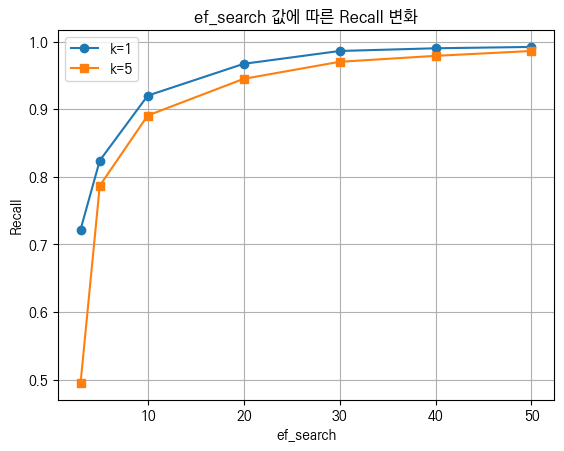

In [30]:
import matplotlib.pyplot as plt
plt.rc('font', family='KoPubDotum Medium')

ef_search = list(result.keys())
k1 = [result[k][1] for k in ef_search]
k5 = [result[k][5] for k in ef_search]

plt.plot(ef_search, k1, marker='o', label='k=1')
plt.plot(ef_search, k5, marker='s', label='k=5')

plt.xlabel('ef_search')
plt.ylabel('Recall')
plt.title('ef_search 값에 따른 Recall 변화')
plt.legend()
plt.grid(True)
plt.show()